In [9]:
import numpy
import numpy as np
from qutip import *

#Paramètres du systeme physique
N=3 #Taille du réseau
T=100
gamma = 0.4
#OPÉRATEURS DE SPIN
# - Définition des opérateurs de Pauli
sx = sigmax()
sy = sigmay()
sz = sigmaz()
n = 0.5*(1+sz)

id_= tensor([qeye(2)]*(N*N-1)) #identity operators in the Hibert space


sx = [[tensor(id_, sigmax())]*N]*N     #Spin observables in the bath in x direction
sx[1][1] = tensor(sigmax(), id_)       #System spin operator in x direction
sx_list = sx

sy = [[tensor(id_, sigmay())]*N]*N     #Spin observables in the bath in y direction
sy[1][1] = tensor(sigmay(), id_)       #System spin operator in y direction
sy_list = sy

sz = [[tensor(id_, sigmaz())]*N]*N     #Spin observables in the bath in y direction
sz[1][1] = tensor(sigmaz(), id_)       #System spin operator in z direction
sz_list = sz

n_B = [[tensor(id_, 0.5*(1 + sigmaz()))]*N]*N
n_B[1][1] = tensor(0.5*(1 + sigmaz()), id_)
n_list = n_B

#HAMILTONIEN DU SYSTEME (CONDITIONS AUX LIMITES OUVERTS)
def H2D_OBC(omega, V, alpha, delta):
    #
    #Hamiltonien d’interaction
    H_int = 0
    for i in range(N):
        for j in range(N):
            for ii in range(1,N):
                for jj in range(1,N):
                    if ii < jj:
                        H_int+= V/(abs(ii-jj)**alpha)*(n_list[i][j])*(n_list[(i+ii)%N][(j+jj)%N])
    #Hamiltonien libre
    H0_l = 0 #Hamiltonien du champ longitudinal
    H0_t = 0 #Hamiltonien du champ transversale
    for i in range(N):
        for j in range(N):
            H0_l += -delta*n_list[i][j]
            H0_t += omega*sx_list[i][j]
    H = H0_t + H0_l + H_int
    return(H)

# Etat initial du systeme
a = np.random.uniform(0.01,0.7)
hro0_S = Qobj([[1-a,0],[0,a]])
# print(hro0_S)
hro0 = tensor(hro0_S, id_)
print('Etat initial:',hro0_S)
#hro0 = tensor(Qobj([[0.52066722,0], [0, 0.59590664]]), qeye(2**(N-1)))

#List fo Lindblad oparators
L0 = [[np.sqrt(gamma)*(tensor(id_, 0.5*(1 + sigmaz())))]*N]*N
L0[1][1] = np.sqrt(gamma)*(tensor(0.5*(1 + sigmaz()), id_))
L = L0

H = H2D_OBC(omega=1, V=5, alpha=8, delta=0)
tlist = np.linspace(0.0, 1.0, 100)
result = mesolve(H, hro0, tlist, L, [sx_list[1][1], sy_list[1][1], sz_list[1][1]] )


# Donnees d'entrees
tlistx = np.linspace(0, 1, 100)
resultx = mesolve(H, hro0, tlistx, L, [sx_list[1][1], sy_list[1][1], sz_list[1][1]], args=None, options=None, progress_bar=None, _safe_mode=True)
X0 = resultx.expect[0]
X1 = resultx.expect[1] 
X2 = resultx.expect[2]
#print(X0.shape)

# Etiquettes
tlisty = np.linspace(0+0.02, 1, 100)
resulty = mesolve(H, hro0, tlisty, L, [sx_list[1][1], sy_list[1][1], sz_list[1][1]], args=None, options=None, progress_bar=None, _safe_mode=True)
Y0 = resulty.expect[0]
Y1 = resulty.expect[1]
Y2 = resulty.expect[2]

X = np.transpose([np.ones(100), X0, X1, X2])  #Ensemble des donnee d'entree de formation
Y = np.transpose([np.ones(100), Y0, Y1, Y2])  #Ensemble des etiquettes

from numpy.random import rand
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 40, train_size = 60, random_state = None, shuffle=False, stratify = None)

model = MLPRegressor(hidden_layer_sizes =(100,100,100,100), activation='relu', solver='adam', alpha = 0.1)

#Apprentissage du modele avec l'ensemble des donnees d'apprentissage
model.fit(X_train, Y_train)

#Evaluation de la performence du modele avec l'ensemble des donnees de test
Y_pred = model.predict(X_test)
mse = mean_squared_error(Y_test, Y_pred)
print('mean square error:', mse)

#Valeux predicte pour chaque observable du systeme
Y_pred_X = Y_pred[:,1]
Y_pred_Y = Y_pred[:,2]
Y_pred_Z = Y_pred[:,3]


#Visualisation graphique des valeurs compratives
import matplotlib.pyplot as plt

Etat initial: Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.47481559 0.        ]
 [0.         0.52518441]]
mean square error: 0.32075484891680595


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


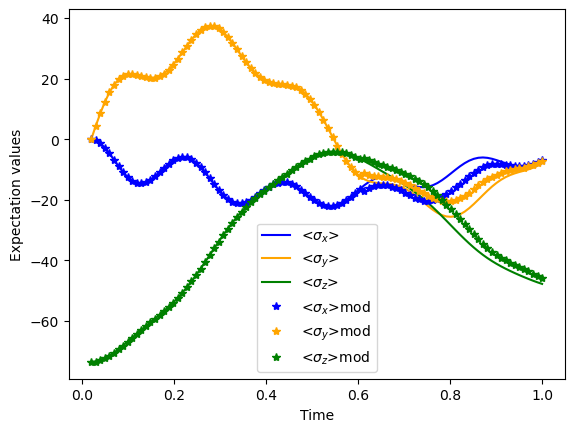

In [5]:
#Visualisation graphique des valeurs compratives
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
#Dynamique exacte
ax.plot(resulty.times, resultx.expect[0], label='<$\sigma_x$>', color='blue')
ax.plot(resulty.times, resultx.expect[1], label='<$\sigma_y$>', color='orange')
ax.plot(resulty.times, resultx.expect[2], label='<$\sigma_z$>', color='green')
#Apprentissage
ax.plot(resulty.times[0:60], X_train[:,1], linestyle='None', label='<$\sigma_x$>mod', color='blue', marker='*')
ax.plot(resulty.times[0:60], X_train[:,2], linestyle='None', label='<$\sigma_y$>mod', color='orange', marker='*')
ax.plot(resulty.times[0:60], X_train[:,3], linestyle='None', label='<$\sigma_z$>mod', color='green', marker='*')
#Extrapolation ou prediction
ax.plot(resulty.times[60:100], Y_pred_X, linestyle='None', color='blue', marker='*')
ax.plot(resulty.times[60:100], Y_pred_Y, linestyle='None', color='orange', marker='*')
ax.plot(resulty.times[60:100], Y_pred_Z, linestyle='None', color='green',marker='*')
ax.set_xlabel('Time')
ax.set_ylabel('Expectation values')
plt.legend()
plt.show()

In [10]:
alpha_list = np.arange(0, 22, 4)
V_list = np.arange(0, 2.1, 0.2)
omega = 1

mae_list = []
mse_list = []
for alpha in alpha_list:
    for V in V_list:
        # Evaluation des valeurs a travert la fonction mesolve
        H = H2D_OBC(omega, V, alpha, delta=0)

        # Generation des donnees d'apprentissage du MLP

        # Donnees d'entrees
        tlistx = np.linspace(0, 1, 100)
        resultx = mesolve(H, hro0, tlistx, L, [sx_list[1][1], sy_list[1][1], sz_list[1][1]], args=None, options=None, progress_bar=None, _safe_mode=True)
        X0 = resultx.expect[0]
        X1 = resultx.expect[1]
        X2 = resultx.expect[2]
        # Donnees de sortie
        tlisty = np.linspace(0+0.1, 1, 100)
        resulty = mesolve(H, hro0, tlistx, L, [sx_list[1][1], sy_list[1][1], sz_list[1][1]], args=None, options=None, progress_bar=None, _safe_mode=True)
        Y0 = resulty.expect[0]
        Y1 = resulty.expect[1]
        Y2 = resulty.expect[2]

        X = np.transpose([np.ones(100), X0, X1, X2])  #Ensemble des donnee d'entree de formation
        Y = np.transpose([np.ones(100), Y0, Y1, Y2])  #Ensemble des sorties relles

        #Division de l'ensemble des donnees en donnees de formation et en donnees de test
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 40, train_size = 60, random_state = None, shuffle=False, stratify = None)


        # Architechture neuronale du perceptron multicouche
        model = MLPRegressor(hidden_layer_sizes =(200, 200, 200), activation='relu', solver='adam', alpha = 0.001)

        #Apprentissage du modele avec l'ensemble des donnees d'apprentissage
        model.fit(X_train, Y_train)

        #Evaluation de la performence du modele avec l'ensemble des donnees de test
        Y_pred = model.predict(X_test)
        mse = mean_squared_error(Y_test, Y_pred)
        mae = mean_absolute_error(Y_test, Y_pred)
        mse_list.append(mse)
        mae_list.append(mae)
print(mae_list)


[1.3539413396882292, 1.1932991497793533, 1.1431190861343006, 1.0956740261657947, 0.8671677833851013, 0.5514364117276149, 0.40678835887945086, 0.4832686247223815, 0.5337641567145249, 0.3893627279738473, 0.5035976957896044, 1.0289972241546768, 1.2798329960423245, 1.189793452372414, 0.9528092785212771, 1.0568748094390306, 0.6737022561024919, 0.5181693010704737, 0.45106976117068903, 0.4307078543267014, 0.5986994924147491, 0.4399887540900702, 0.9916135431995969, 1.176352777484607, 1.1173281241228015, 1.114305921222185, 0.846943383175832, 0.4296525255098524, 0.44955498758484647, 0.5244317851219589, 0.8194341940487908, 0.32822660603262366, 0.6339494947085339, 1.6521306969094374, 1.3418742801465982, 1.1639648069864326, 0.9876421603786423, 1.135169370280031, 0.7398019895361043, 0.6437931394577361, 0.457453583064122, 0.48408148624132635, 0.5165383118032169, 0.5998875112264033, 1.4139680214751795, 1.1161407406652026, 1.3774072087488625, 1.164996255541765, 1.0472477666862592, 0.6790113752693469, 0

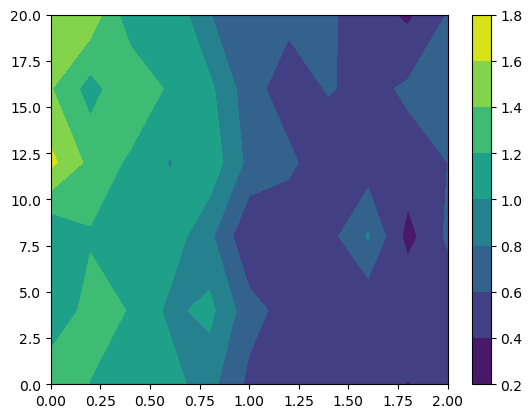

In [12]:
import matplotlib.pyplot as plt
import numpy as np

z = np.array(mae_list)
#print(mae_list)
X, Y = np.meshgrid(V_list, alpha_list)

Z = z.reshape(Y.shape)

fig = plt.figure()
ax1 = plt.contourf(X, Y, Z)
plt.colorbar(ax1)
#ax1.set_ylabel('Alpha')
#ax1.set_xlabel('V')
plt.show()

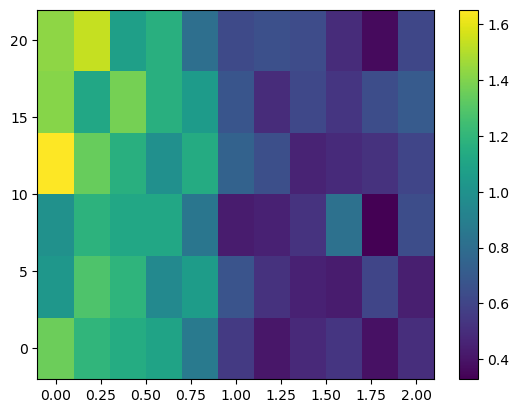

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Create a 2-D grid from the 1-D arrays
X, Y = np.meshgrid(V_list, alpha_list)

# Define a function to plot
Z = z.reshape(Y.shape)

# Create a pseudocolor plot with a non-regular rectangular grid
plt.pcolormesh(X, Y, Z)
plt.colorbar() # Add a color bar to show the scale

# Show the plot
plt.show()

In [15]:
alpha_list = np.arange(0, 22, 4)
V_list = np.arange(0, 2.1, 0.2)
omega = 1

mae_list = []
mse_list = []
hro0_S = Qobj([[1-a,0],[0,a]])
# print(hro0_S)
hro0_list = [tensor(Qobj([[1-np.random.uniform(0.01,0.7),0],[0,np.random.uniform(0.01,0.7)]]), id_),
            tensor(Qobj([[1-np.random.uniform(0.01,0.7),0],[0,np.random.uniform(0.01,0.7)]]), id_),
            tensor(Qobj([[1-np.random.uniform(0.01,0.7),0],[0,np.random.uniform(0.01,0.7)]]), id_),
            tensor(Qobj([[1-np.random.uniform(0.01,0.7),0],[0,np.random.uniform(0.01,0.7)]]), id_),
            tensor(Qobj([[1-np.random.uniform(0.01,0.7),0],[0,np.random.uniform(0.01,0.7)]]), id_),
            tensor(Qobj([[1-np.random.uniform(0.01,0.7),0],[0,np.random.uniform(0.01,0.7)]]), id_),
            tensor(Qobj([[1-np.random.uniform(0.01,0.7),0],[0,np.random.uniform(0.01,0.7)]]), id_),
            tensor(Qobj([[1-np.random.uniform(0.01,0.7),0],[0,np.random.uniform(0.01,0.7)]]), id_),
            tensor(Qobj([[1-np.random.uniform(0.01,0.7),0],[0,np.random.uniform(0.01,0.7)]]), id_),
            tensor(Qobj([[1-np.random.uniform(0.01,0.7),0],[0,np.random.uniform(0.01,0.7)]]), id_)]
for hro0 in hro0_list:
    for V in V_list:
        # Evaluation des valeurs a travert la fonction mesolve
        H = H2D_OBC(omega, V, alpha=2, delta=0)

        # Generation des donnees d'apprentissage du MLP

        # Donnees d'entrees
        tlistx = np.linspace(0, 1, 100)
        resultx = mesolve(H, hro0, tlistx, L, [sx_list[1][1], sy_list[1][1], sz_list[1][1]], args=None, options=None, progress_bar=None, _safe_mode=True)
        X0 = resultx.expect[0]
        X1 = resultx.expect[1]
        X2 = resultx.expect[2]
        # Donnees de sortie
        tlisty = np.linspace(0+0.1, 1, 100)
        resulty = mesolve(H, hro0, tlistx, L, [sx_list[1][1], sy_list[1][1], sz_list[1][1]], args=None, options=None, progress_bar=None, _safe_mode=True)
        Y0 = resulty.expect[0]
        Y1 = resulty.expect[1]
        Y2 = resulty.expect[2]

        X = np.transpose([np.ones(100), X0, X1, X2])  #Ensemble des donnee d'entree de formation
        Y = np.transpose([np.ones(100), Y0, Y1, Y2])  #Ensemble des sorties relles

        #Division de l'ensemble des donnees en donnees de formation et en donnees de test
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 40, train_size = 60, random_state = None, shuffle=False, stratify = None)


        # Architechture neuronale du perceptron multicouche
        model = MLPRegressor(hidden_layer_sizes =(200, 200, 200), activation='relu', solver='adam', alpha = 0.001)

        #Apprentissage du modele avec l'ensemble des donnees d'apprentissage
        model.fit(X_train, Y_train)

        #Evaluation de la performence du modele avec l'ensemble des donnees de test
        Y_pred = model.predict(X_test)
        mse = mean_squared_error(Y_test, Y_pred)
        mae = mean_absolute_error(Y_test, Y_pred)
        mse_list.append(mse)
        mae_list.append(mae)
print(mae_list)


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_

[2.7568973625719737, 3.282361136715865, 2.811769355206201, 2.180818701323209, 1.8557969311123315, 1.4725585111363673, 1.2683239803101622, 1.1924382743936708, 1.186005135735031, 1.35345544468327, 1.1723448559226175, 2.112122986221977, 2.188845600396389, 1.767668826148039, 1.4579642439872544, 1.45314038529351, 1.2463884324503647, 0.8365493116736937, 0.9931491111004694, 0.9341323167163164, 0.5174698074035612, 0.9971368167976125, 2.936184323529249, 4.061968476331986, 4.086734332442278, 3.4425807654741964, 3.057148231718028, 1.9292167899399715, 1.600815831219614, 1.83473026491439, 2.186623434929165, 1.5487386544859931, 1.9912036579446921, 9.257087723336456, 7.955118402826397, 9.492534542256902, 3.9917829857971294, 4.571073471802896, 4.105246194681243, 2.3067920807169675, 2.5218298881451524, 3.1033736284879065, 2.687835670274676, 3.3577542738795105, 17.237595085423223, 18.635348973429164, 19.045853252661566, 16.673697132334517, 11.00774879187599, 9.925913002970962, 5.8531683681568, 6.3893897

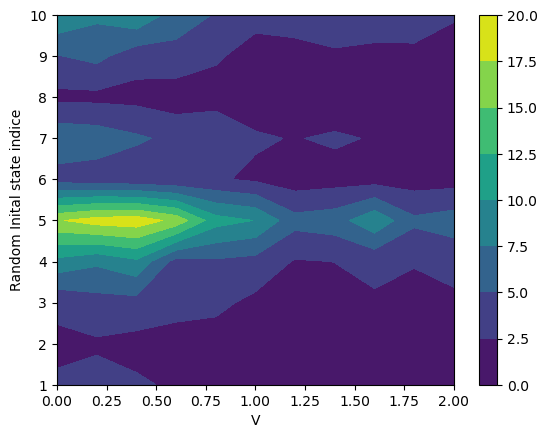

In [19]:
z = np.array(mae_list)
#print(mae_list)
X, Y = np.meshgrid(V_list, [1,2,3,4,5,6,7,8,9,10])

Z = z.reshape(Y.shape)

fig = plt.figure()
ax1 = plt.contourf(X, Y, Z)
plt.colorbar(ax1)
plt.xlabel('V')
plt.ylabel('Random Inital state indice')
plt.show()